<a href="https://colab.research.google.com/github/DrSunday1405/ITU-ML5G-PS-008-Network-failure-classification-model-using-NDT--MLAB/blob/main/MLP_based_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, mutual_info_classif

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
data_raw_tab_A = pd.read_csv('drive/My Drive/2023_KDDI_challenge_digtal twin_dataset/train_data_A.csv')
data_raw_tab_C_train = pd.read_csv('drive/My Drive/2023_KDDI_challenge_digtal twin_dataset/train_data_C.csv')
data_raw_tab_C_test = pd.read_csv('drive/My Drive/2023_KDDI_challenge_digtal twin_dataset/test_data_C.csv')
data_raw_tab_A.head()

,time,source_name,y_true(fc),amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,amfx1_ens3_statistics.out-unicast-pkts,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,20210128175112-4_20210128175200,network-5gc-a,udmx1_vcpu-overload-start,0,0,0,1,1,1,1,...,0,0,-3308,0,-0.22,0.030,0,0.0,-0.030,0.24
1,20210128175529-6_20210128175610,network-5gc-a,normal,0,0,0,1,1,1,1,...,-4,0,79536,4,0.07,-0.055,0,0.0,0.095,-0.11
2,20210128175945-8_20210128180030,network-5gc-a,normal,0,0,0,1,1,1,1,...,0,0,-3756,0,0.09,0.000,0,0.0,0.090,-0.28
3,20210128180403-10_20210128180450,network-5gc-a,udmx1_ens4_interface-loss-start-70,0,0,0,1,1,1,1,...,-4,0,85520,4,0.05,0.050,0,0.0,0.050,-0.15
4,20210128180817-12_20210128180900,network-5gc-a,normal,0,0,0,1,1,1,1,...,0,0,-5044,0,0.31,-0.150,0,0.0,-0.100,-0.11


In [29]:
data_raw_tab_C_train.head()

,time,source_name,y_true(fc),amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,amfx1_ens3_statistics.out-unicast-pkts,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,20210128175112-4_20210128175200,network-5gc-c,normal,0,0,0,1,1,1,1,...,8,0,-148496,-8,-0.095,0.18,0,0.0,0.045,-4.500000e-02
1,20210128175529-6_20210128175610,network-5gc-c,udmx1_vcpu-overload-start,0,0,0,1,1,1,1,...,0,0,-24,0,-0.095,0.02,0,0.0,0.010,8.000000e-02
2,20210128175945-8_20210128180030,network-5gc-c,amfx1_memory-stress-start,0,0,0,1,1,1,1,...,-1,0,4092,1,-0.100,0.00,0,0.0,0.100,4.160000e-17
3,20210128180403-10_20210128180450,network-5gc-c,normal,0,0,0,1,1,1,1,...,0,0,244,0,0.350,-0.02,0,0.0,-0.030,-3.100000e-01
4,20210128180817-12_20210128180900,network-5gc-c,normal,0,0,0,1,1,1,1,...,0,0,160,0,-0.130,0.00,0,0.0,0.140,-5.000000e-03


In [30]:
data_raw_tab_A.dtypes    # check the data type for each column

time                                                 object
source_name                                          object
y_true(fc)                                           object
amfx1_ens3_oper-status                                int64
amfx1_ens3_phys-address                               int64
                                                     ...   
upfx7_per-core-stats.per-core-stat.io-wait_value    float64
upfx7_per-core-stats.per-core-stat.nice_value         int64
upfx7_per-core-stats.per-core-stat.sirq_value       float64
upfx7_per-core-stats.per-core-stat.system_value     float64
upfx7_per-core-stats.per-core-stat.user_value       float64
Length: 4121, dtype: object

In [31]:
data_raw_tab_A.describe()

,amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,amfx1_ens3_statistics.out-unicast-pkts,amfx1_ens3_oper-status_value,amfx1_ens3_phys-address_value,amfx1_ens3_speed_value,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
count,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,...,3645.000000,3645.0,3645.000000,3645.000000,3645.000000,3645.000000,3645.0,3645.000000,3645.000000,3645.000000
mean,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.032647,0.0,-939.736626,-0.032647,0.002632,0.009392,0.0,0.000571,-0.001115,-0.014742
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.003434,0.0,60210.989674,3.003434,1.298748,0.876834,0.0,0.033653,0.174028,0.611928
min,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-12.000000,0.0,-240232.000000,-12.000000,-55.085000,-10.515000,0.0,-0.200000,-7.655000,-34.610000
25%,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-2.000000,0.0,-34500.000000,-2.000000,-0.135000,-0.070000,0.0,0.000000,-0.070000,-0.105000
50%,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,28.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2.000000,0.0,34320.000000,2.000000,0.130000,0.060000,0.0,0.000000,0.070000,0.100000
max,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,12.000000,0.0,239980.000000,12.000000,53.805000,50.640000,0.0,0.200000,2.555000,1.835000


In [32]:
# check the distributin of label column
fig=px.histogram(data_raw_tab_A,
        x="y_true(fc)",
        hover_data=data_raw_tab_A.columns,
        title="Each label Ratio in the train_data_A")
fig.show()

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [33]:
# Checking for NULLs in the data
null_count = data_raw_tab_A.isnull().sum()
print(type(null_count))
print(null_count.nunique())
print(null_count)

<class 'pandas.core.series.Series'>
1
time                                                0
source_name                                         0
y_true(fc)                                          0
amfx1_ens3_oper-status                              0
amfx1_ens3_phys-address                             0
                                                   ..
upfx7_per-core-stats.per-core-stat.io-wait_value    0
upfx7_per-core-stats.per-core-stat.nice_value       0
upfx7_per-core-stats.per-core-stat.sirq_value       0
upfx7_per-core-stats.per-core-stat.system_value     0
upfx7_per-core-stats.per-core-stat.user_value       0
Length: 4121, dtype: int64


In [34]:
# Remove the mutual columns that contain only one value from train_A and train_C
train_A_col_n1 = []
train_C_col_n1 = []
common_col_n1 = []

for col in data_raw_tab_A.columns:
  if data_raw_tab_A[col].nunique() == 1:
    train_A_col_n1.append(col)
print(len(train_A_col_n1))
print(train_A_col_n1)
print("\n")

for col in data_raw_tab_C_train.columns:
  if data_raw_tab_C_train[col].nunique() == 1:
    train_C_col_n1.append(col)
print(len(train_C_col_n1))
print(train_C_col_n1)
print("\n")

for i in train_A_col_n1:
  if i in train_C_col_n1:
    common_col_n1.append(i)
print(len(common_col_n1))
print(common_col_n1)

data_raw_tab_A = data_raw_tab_A.drop(columns=common_col_n1)
data_raw_tab_C_train = data_raw_tab_C_train.drop(columns=common_col_n1)
data_raw_tab_C_test = data_raw_tab_C_test.drop(columns=common_col_n1)

data_raw_tab_A.head()

2191
['source_name', 'amfx1_ens3_oper-status', 'amfx1_ens3_phys-address', 'amfx1_ens3_speed', 'amfx1_ens3_statistics.in-octets', 'amfx1_ens3_statistics.in-unicast-pkts', 'amfx1_ens3_statistics.out-octets', 'amfx1_ens3_statistics.out-unicast-pkts', 'amfx1_ens3_oper-status_value', 'amfx1_ens3_phys-address_value', 'amfx1_ens3_speed_value', 'amfx1_ens4_oper-status', 'amfx1_ens4_phys-address', 'amfx1_ens4_speed', 'amfx1_ens4_oper-status_value', 'amfx1_ens4_phys-address_value', 'amfx1_ens4_speed_value', 'amfx1_ens5_phys-address', 'amfx1_ens5_statistics.out-octets', 'amfx1_ens5_statistics.out-unicast-pkts', 'amfx1_ens5_oper-status_value', 'amfx1_ens5_phys-address_value', 'amfx1_ens5_speed_value', 'amfx1_lo_oper-status', 'amfx1_lo_phys-address', 'amfx1_lo_speed', 'amfx1_lo_oper-status_value', 'amfx1_lo_phys-address_value', 'amfx1_lo_speed_value', 'ausfx1_ens3_oper-status', 'ausfx1_ens3_phys-address', 'ausfx1_ens3_speed', 'ausfx1_ens3_statistics.in-octets', 'ausfx1_ens3_statistics.in-unicast-pk

,time,y_true(fc),amfx1_ens3_statistics.in-octets_value,amfx1_ens3_statistics.in-unicast-pkts_value,amfx1_ens3_statistics.out-octets_value,amfx1_ens3_statistics.out-unicast-pkts_value,amfx1_ens4_statistics.in-octets,amfx1_ens4_statistics.in-unicast-pkts,amfx1_ens4_statistics.out-octets,amfx1_ens4_statistics.out-unicast-pkts,...,upfx7_memory-stats.committed-percent_value,upfx7_memory-stats.free-number_value,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,20210128175112-4_20210128175200,udmx1_vcpu-overload-start,100146,1505,2550911,2254,1,1,1,1,...,0,3308,0,-3308,0,-0.22,0.030,0.0,-0.030,0.24
1,20210128175529-6_20210128175610,normal,107778,1619,2562513,2332,1,1,1,1,...,0,-79536,-4,79536,4,0.07,-0.055,0.0,0.095,-0.11
2,20210128175945-8_20210128180030,normal,102906,1547,2561033,2301,1,1,1,1,...,0,3756,0,-3756,0,0.09,0.000,0.0,0.090,-0.28
3,20210128180403-10_20210128180450,udmx1_ens4_interface-loss-start-70,45348,676,700993,732,1,1,1,1,...,-1,-85520,-4,85520,4,0.05,0.050,0.0,0.050,-0.15
4,20210128180817-12_20210128180900,normal,105734,1583,2549200,2291,1,1,1,1,...,0,5044,0,-5044,0,0.31,-0.150,0.0,-0.100,-0.11


In [35]:
# Try to conduct the advanced task later, which is using only 10% of the training data from domain C

# Split the dataset into normal and abnormal data
normal_data = data_raw_tab_C_train[data_raw_tab_C_train['y_true(fc)'] == "normal"]
abnormal_data = data_raw_tab_C_train[data_raw_tab_C_train['y_true(fc)'] != "normal"]

print("Testing the data separation from noraml and abnormal")
print(normal_data)
print("\n")
print(abnormal_data)

# Change the data from data_train_C we use to train by adjusting the value: frac. When frac is 1.0, we use 100% of train_data_C
sampled_data = normal_data.sample(frac=1.0, random_state=42)
for label in abnormal_data['y_true(fc)'].unique():
    label_data = abnormal_data[abnormal_data['y_true(fc)'] == label]
    sampled_data = pd.concat([sampled_data, label_data.sample(frac=1.0, random_state=42)])

# Reset the index
sampled_data.reset_index(drop=True, inplace=True)
data_raw_tab_C_train = sampled_data.sample(frac=1, random_state=42)

# sampled_data now contains the 10% subset of the original dataset with balanced class distribution.

Testing the data separation from noraml and abnormal
                                  time y_true(fc)  \
0      20210128175112-4_20210128175200     normal   
3     20210128180403-10_20210128180450     normal   
4     20210128180817-12_20210128180900     normal   
5     20210128181232-14_20210128181320     normal   
6     20210128181646-16_20210128181730     normal   
..                                 ...        ...   
450  20210130031042-949_20210130031130     normal   
454  20210130032752-957_20210130032840     normal   
455  20210130033207-959_20210130033250     normal   
456  20210130033621-961_20210130033710     normal   
457  20210130034037-963_20210130034120     normal   

     amfx1_ens3_statistics.in-octets_value  \
0                                    55772   
3                                    54514   
4                                    58132   
5                                    56694   
6                                    52740   
..                                

In [36]:
fig=px.histogram(data_raw_tab_C_train,
        x="y_true(fc)",
        hover_data=data_raw_tab_C_train.columns,
        title="Each label Ratio in the sample data")
fig.show()

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [37]:
# Separate the labels and features in the dataset and transform them into proper data type

data_input_features_A = data_raw_tab_A.iloc[:,2:]
label_A = data_raw_tab_A.iloc[:,1]

data_input_features_C_train = data_raw_tab_C_train.iloc[:,2:]
label_C_train = data_raw_tab_C_train.iloc[:,1]
data_input_features_C_test = data_raw_tab_C_test.iloc[:,2:]
label_C_test = data_raw_tab_C_test.iloc[:,1]


print(data_input_features_C_train)
print("\n")
print(label_C_test)


     amfx1_ens3_statistics.in-octets_value  \
124                                  52564   
30                                   55172   
199                                  55566   
439                                  68816   
154                                  42234   
..                                     ...   
106                                  61216   
270                                  58608   
348                                  20182   
435                                  45608   
102                                  57252   

     amfx1_ens3_statistics.in-unicast-pkts_value  \
124                                          784   
30                                           824   
199                                          831   
439                                         1184   
154                                          631   
..                                           ...   
106                                         1070   
270                            

In [38]:
print(data_input_features_C_test)


     amfx1_ens3_statistics.in-octets_value  \
0                                    70578   
1                                    70114   
2                                    70514   
3                                   171725   
4                                    59322   
..                                     ...   
868                                 151565   
869                                  32794   
870                                  33237   
871                                  44308   
872                                  45262   

     amfx1_ens3_statistics.in-unicast-pkts_value  \
0                                           1211   
1                                           1203   
2                                           1211   
3                                            868   
4                                           1039   
..                                           ...   
868                                          410   
869                            

In [39]:
# Conduct data preprocessing of Min-Max scaling
data_input_features_A = preprocessing.MinMaxScaler().fit_transform(data_input_features_A)
data_input_features_A = pd.DataFrame(data_input_features_A)

scaler = preprocessing.MinMaxScaler()
scaler.fit(data_input_features_C_train)
data_input_features_C_train = scaler.transform(data_input_features_C_train)

data_input_features_C_test = scaler.transform(data_input_features_C_test)

data_input_features_C_train = pd.DataFrame(data_input_features_C_train)
data_input_features_C_test = pd.DataFrame(data_input_features_C_test)

print(data_input_features_C_test)



         0         1         2         3     4     5     6     7         8     \
0    0.279838  0.831169  0.837944  0.870906   0.0   0.0   0.0   0.0  0.600248   
1    0.277398  0.824242  0.842498  0.862235   0.0   0.0   0.0   0.0  0.606120   
2    0.279502  0.831169  0.830190  0.876686   0.0   0.0   0.0   0.0  0.601663   
3    0.811723  0.534199  0.046510  0.157033   0.0   0.0   0.0   0.0  0.030952   
4    0.220648  0.682251  0.827409  0.734104   0.0   0.0   0.0   0.0  0.589671   
..        ...       ...       ...       ...   ...   ...   ...   ...       ...   
868  0.705711  0.137662  0.067420  0.119461   0.0   0.0   0.0   0.0  0.047683   
869  0.081150  0.204329  0.503373  0.429672   0.0   0.0   0.0   0.0  0.366714   
870  0.083479  0.209524  0.501541  0.449904   0.0   0.0   0.0   0.0  0.366961   
871  0.141697  0.355844  0.824246  0.737958   0.0   0.0   0.0   0.0  0.594906   
872  0.146713  0.367100  0.838177  0.746628   0.0   0.0   0.0   0.0  0.596675   

         9     ...  1925   

In [40]:
# Encode the labels

encoder = preprocessing.LabelEncoder()
encoded_label_A = encoder.fit_transform(label_A)
encoded_label_C_train = encoder.fit_transform(label_C_train)
encoded_label_C_test = encoder.fit_transform(label_C_test)

print(label_A)
print("\n")
print("After encoding the label:")
print(encoded_label_A)
print(type(encoded_label_A))
print(len(encoded_label_A))
print("\n")

print("检查输出")
print(encoded_label_C_train.shape)
print(encoded_label_C_train)
print("\n")

print(encoded_label_C_test.shape)
print(encoded_label_C_test)



0                udmx1_vcpu-overload-start
1                                   normal
2                                   normal
3       udmx1_ens4_interface-loss-start-70
4                                   normal
                       ...                
3640                                normal
3641                                normal
3642                    udmx1_bridge-delif
3643                                normal
3644                                normal
Name: y_true(fc), Length: 3645, dtype: object


After encoding the label:
[15 10 10 ... 11 10 10]
<class 'numpy.ndarray'>
3645


检查输出
(460,)
[10 10 10  0 10 10 11 10 10 10  9  6 10  8 10  7 10 10 14 10 10 10  0 10
 10 10 10 10 10 10 10 10  9 10  4  3 11 10 10  3 13  1 10 10 10  0 10 10
 13 10 10 10  0  0 10 10 15 11 10 10 11 10 10 10  5 10  2 10 10 10  4  2
 10 10  1 10 10 10  0 10 10 14  9 12 10 10 10 10 10 10  7 10  9 10 10 10
 10 10 10 10 10 10 10 11 10 11 10 10 10 10 10 10 10 10  6 10 10 10 10  1
 10 10 13 10  7 10 10

In [41]:
data_input_features_A.head()

,0,1,2,3,4,5,6,7,8,9,...,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934
0,0.012997,0.234073,0.901070,0.650838,1.0,1.0,1.0,1.0,0.960578,0.965517,...,0.473684,0.506626,0.500000,0.493374,0.500000,0.503857,0.172431,0.5,0.746817,0.956235
1,0.014125,0.254136,0.905277,0.675047,1.0,1.0,1.0,1.0,0.956480,0.957680,...,0.473684,0.334111,0.333333,0.665889,0.666667,0.506520,0.171041,0.5,0.759060,0.946632
2,0.013405,0.241464,0.904740,0.665425,1.0,1.0,1.0,1.0,0.959883,0.959248,...,0.473684,0.507559,0.500000,0.492441,0.500000,0.506704,0.171940,0.5,0.758570,0.941967
3,0.004895,0.088173,0.230371,0.178461,1.0,1.0,1.0,1.0,0.236604,0.228840,...,0.421053,0.321650,0.333333,0.678350,0.666667,0.506337,0.172758,0.5,0.754652,0.945534
4,0.013823,0.247800,0.900450,0.662322,1.0,1.0,1.0,1.0,0.954946,0.957680,...,0.473684,0.510241,0.500000,0.489759,0.500000,0.508724,0.169487,0.5,0.739961,0.946632


In [42]:
print(data_input_features_C_test)

         0         1         2         3     4     5     6     7         8     \
0    0.279838  0.831169  0.837944  0.870906   0.0   0.0   0.0   0.0  0.600248   
1    0.277398  0.824242  0.842498  0.862235   0.0   0.0   0.0   0.0  0.606120   
2    0.279502  0.831169  0.830190  0.876686   0.0   0.0   0.0   0.0  0.601663   
3    0.811723  0.534199  0.046510  0.157033   0.0   0.0   0.0   0.0  0.030952   
4    0.220648  0.682251  0.827409  0.734104   0.0   0.0   0.0   0.0  0.589671   
..        ...       ...       ...       ...   ...   ...   ...   ...       ...   
868  0.705711  0.137662  0.067420  0.119461   0.0   0.0   0.0   0.0  0.047683   
869  0.081150  0.204329  0.503373  0.429672   0.0   0.0   0.0   0.0  0.366714   
870  0.083479  0.209524  0.501541  0.449904   0.0   0.0   0.0   0.0  0.366961   
871  0.141697  0.355844  0.824246  0.737958   0.0   0.0   0.0   0.0  0.594906   
872  0.146713  0.367100  0.838177  0.746628   0.0   0.0   0.0   0.0  0.596675   

         9     ...  1925   

In [43]:
# Select the mutual features from domain A and domain C according to their mutual information
# The most important part in this project, which is even more time-consuming than model training process


t0 = time.time()
k_best_A = SelectKBest(score_func=mutual_info_classif, k=150)
# By changing the value K, we can evaluate the performance when we use different number of selected features
X_new_A = k_best_A.fit_transform(data_input_features_A, encoded_label_A)


t1 = time.time()
print("Time for domain A")
print(t1 - t0)
print("\n")

selected_features_A = k_best_A.get_support(indices=True)
print("Selected feature indices for domain A:\n", selected_features_A)
print("\n")

t0 = time.time()
k_best_C = SelectKBest(score_func=mutual_info_classif, k=150)
X_new_C = k_best_C.fit_transform(data_input_features_C_train, encoded_label_C_train)
# print("After feature selection:")
# print(type(X_new))
# print(X_new)
# print("\n")

t1 = time.time()
print("Time for domain C")
print(t1 - t0)
print("\n")

selected_features_C = k_best_C.get_support(indices=True)
print("Selected feature indices for domain C:\n", selected_features_C)
print("\n")



Time for domain A
57.203718423843384


Selected feature indices for domain A:
 [   0    1    2    3    8    9   10   11   12   13   14   15   18   19
   20   21   22   23   24   25   26   27   28   29   30   31   32   33
   34   35   39   40   41   42   43   44   45   46   47   48   49   50
   51  164  371  487  673  679  680  683  684  693  694  695  696  697
  698  703  704  705  706  707  708  713  714  715  716  721  722  723
  724  947  986  992  995  996  997 1004 1005 1006 1007 1008 1009 1010
 1011 1012 1013 1014 1015 1016 1017 1018 1019 1021 1022 1023 1027 1029
 1031 1032 1034 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050
 1051 1052 1054 1055 1135 1161 1248 1251 1460 1583 1584 1585 1586 1589
 1591 1593 1594 1596 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611
 1612 1613 1614 1615 1616 1617 1618 1619 1675 1818]


Time for domain C
29.413763999938965


Selected feature indices for domain C:
 [   0    1    2    3    8    9   10   11   12   13   16   18   19   20
   21  

In [44]:
common_features = np.intersect1d(selected_features_A, selected_features_C)
print(common_features.shape)
input_dim = len(common_features)
print(input_dim)
print(common_features)

(107,)
107
[   0    1    2    3    8    9   10   11   12   13   18   19   20   21
   26   30   31   32   33   34   35   39   40   41   42   43   46   47
   48   50   51  679  680  683  696  703  704  705  706  707  708  713
  714  715  716  721  722  723  724  992  995  996  997 1004 1007 1008
 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1021 1022 1023 1027
 1029 1031 1032 1034 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 1051 1054 1055 1589 1591 1593 1594 1596 1604 1605 1606 1607 1608
 1609 1610 1611 1612 1613 1614 1615 1618 1619]


In [45]:
data_input_features_A = data_input_features_A[common_features]

data_input_features_C_train = data_input_features_C_train[common_features]
data_input_features_C_test = data_input_features_C_test[common_features]


print(data_input_features_A)
print("\n")
print(data_input_features_C_train)
print("\n")

          0         1         2         3         8         9         10    \
0     0.012997  0.234073  0.901070  0.650838  0.960578  0.965517  0.984176   
1     0.014125  0.254136  0.905277  0.675047  0.956480  0.957680  0.968767   
2     0.013405  0.241464  0.904740  0.665425  0.959883  0.959248  0.976718   
3     0.004895  0.088173  0.230371  0.178461  0.236604  0.228840  0.154450   
4     0.013823  0.247800  0.900450  0.662322  0.954946  0.957680  0.971833   
...        ...       ...       ...       ...       ...       ...       ...   
3640  0.009277  0.167371  0.886071  0.570453  0.956624  0.957680  0.880317   
3641  0.009932  0.178458  0.885550  0.578212  0.954347  0.951411  0.879356   
3642  0.005325  0.095917  0.544092  0.328988  0.584907  0.584639  0.481174   
3643  0.009042  0.162971  0.886879  0.556797  0.958445  0.959248  0.869144   
3644  0.009457  0.170715  0.876006  0.555556  0.958229  0.948276  0.899571   

          11    12    13    ...      1608      1609      1610  

In [46]:
data_input_features_A.head()

,0,1,2,3,8,9,10,11,12,13,...,1608,1609,1610,1611,1612,1613,1614,1615,1618,1619
0,0.012997,0.234073,0.901070,0.650838,0.960578,0.965517,0.984176,0.979192,0.0,0.0,...,0.970588,0.134322,0.131579,0.946292,0.930556,0.053708,0.069444,0.001217,0.991856,0.803963
1,0.014125,0.254136,0.905277,0.675047,0.956480,0.957680,0.968767,0.951040,0.0,0.0,...,0.970588,0.125489,0.118421,0.947343,0.944444,0.052657,0.055556,0.654467,0.179339,0.325835
2,0.013405,0.241464,0.904740,0.665425,0.959883,0.959248,0.976718,0.955936,0.0,0.0,...,0.970588,0.125437,0.118421,0.949647,0.944444,0.050353,0.055556,0.654763,0.180432,0.317125
3,0.004895,0.088173,0.230371,0.178461,0.236604,0.228840,0.154450,0.190942,0.0,0.0,...,0.970588,0.126474,0.118421,0.950460,0.944444,0.049540,0.055556,0.653546,0.179120,0.327750
4,0.013823,0.247800,0.900450,0.662322,0.954946,0.957680,0.971833,0.953488,0.0,0.0,...,0.970588,0.123716,0.118421,0.949927,0.944444,0.050073,0.055556,0.658676,0.175458,0.317986


In [47]:
data_input_features_C_train.head()
print(data_input_features_C_train)
# data_input_features_A = pd.DataFrame(X_new)
# data_input_features_A.head()

# selected_features = k_best.get_support(indices=True)
# print("Selected feature indices:", selected_features)

# # data_input_features_A = pd.DataFrame(data_input_features_A[:, selected_features], columns=[data_input_features_A.columns[i] for i in selected_features])
# # print(data_input_features_A)



         0         1         2         3         8         9         10    \
0    0.185111  0.461472  0.835709  0.857418  0.597878  0.618605  0.658555   
1    0.198825  0.496104  0.807303  0.860308  0.586806  0.602326  0.660996   
2    0.200897  0.502165  0.839427  0.886320  0.598514  0.618605  0.666222   
3    0.270573  0.807792  0.765143  0.797688  0.547435  0.558140  0.609619   
4    0.130790  0.329004  0.828718  0.766859  0.596604  0.600000  0.673354   
..        ...       ...       ...       ...       ...       ...       ...   
455  0.230608  0.709091  0.832391  0.775530  0.587372  0.611628  0.599321   
456  0.216894  0.665801  0.830056  0.753372  0.592006  0.604651  0.628690   
457  0.014829  0.038095  0.051348  0.036609  0.031022  0.032558  0.020368   
458  0.148533  0.369697  0.609596  0.648362  0.444004  0.460465  0.493020   
459  0.209763  0.648485  0.828844  0.758189  0.594163  0.611628  0.627813   

         11    12    13    ...      1608      1609      1610      1611  \
0

In [48]:
print(data_input_features_C_test)

         0         1         2         3         8         9         10    \
0    0.279838  0.831169  0.837944  0.870906  0.600248  0.620930  0.671295   
1    0.277398  0.824242  0.842498  0.862235  0.606120  0.623256  0.681059   
2    0.279502  0.831169  0.830190  0.876686  0.601663  0.620930  0.680182   
3    0.811723  0.534199  0.046510  0.157033  0.030952  0.030233  0.034366   
4    0.220648  0.682251  0.827409  0.734104  0.589671  0.609302  0.585476   
..        ...       ...       ...       ...       ...       ...       ...   
868  0.705711  0.137662  0.067420  0.119461  0.047683  0.046512  0.038065   
869  0.081150  0.204329  0.503373  0.429672  0.366714  0.369767  0.366962   
870  0.083479  0.209524  0.501541  0.449904  0.366961  0.372093  0.367534   
871  0.141697  0.355844  0.824246  0.737958  0.594906  0.611628  0.600236   
872  0.146713  0.367100  0.838177  0.746628  0.596675  0.625581  0.588756   

         11    12    13    ...      1608      1609      1610      1611  \
0

In [49]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu118
True


In [50]:
# 尝试不使用卷积层，就直接使用最普通的全连接神经网络
# class Net(nn.Module):
#   def __init__(self):
#     super(Net, self).__init__()    # 这个super 函数得捣鼓一下，里面要有什么参数

#     self.model = nn.Sequential(
#         nn.Linear(1928, 482, bias=True),
#         nn.Tanh(),     # 话说它这里如何使最终输出是softmax 概率值啊，需要额外编写吗，最好看一下源码
#         nn.Linear(482, 100, bias=True),
#         nn.Tanh(),
#         nn.Linear(100, 50, bias=True),
#         nn.ReLU(),
#         nn.Linear(50, 16, bias=True),
#     )

#   def forward(self, input):
#     x = self.model(input)
#     return x

class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()
        # self.fc1 = nn.Linear(1000, 512)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, 16)

        # self.fc1 = nn.Linear(800, 400)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(400, 200)
        # self.fc3 = nn.Linear(200, 16)

        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 16)

        # self.fc1 = nn.Linear(600, 300)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(300, 150)
        # self.fc3 = nn.Linear(150, 16)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [51]:
# Assign the model
model = MLP_Net()

In [52]:
# Setting the hyperparameter for training in domain A
num_epoch = 40
batch_size = 45
learning_rate = 0.001   # Might need further improvement later
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [53]:
print(type(data_input_features_C_test.values))
print(data_input_features_C_test.values)

<class 'numpy.ndarray'>
[[0.27983825 0.83116883 0.83794416 ... 0.67460155 0.07913804 0.08993428]
 [0.27739829 0.82424242 0.84249822 ... 0.67238796 0.08438476 0.09564165]
 [0.2795017  0.83116883 0.83018971 ... 0.67603188 0.07726421 0.08785887]
 ...
 [0.08347926 0.20952381 0.50154144 ... 0.6768492  0.07539038 0.08232446]
 [0.14169651 0.35584416 0.82424625 ... 0.67599782 0.07726421 0.08976133]
 [0.14671315 0.36709957 0.83817679 ... 0.67701948 0.07788882 0.08630232]]


In [54]:
# Set up the dataset
Input_A = torch.from_numpy(data_input_features_A.values)   # The data type of dataframe.value is numpy
encoded_label_A = torch.from_numpy(encoded_label_A)

print('Before changing the format of data:')
print(Input_A.size())
print(Input_A.dtype)
print(encoded_label_A.size())
print(encoded_label_A.dtype)

Input_A = Input_A.to(torch.float32)
encoded_label_A = encoded_label_A.to(torch.float32)
print("After changing the format of data:")
print(Input_A.size())
print(Input_A.dtype)
print(encoded_label_A.size())
print(encoded_label_A.dtype)
train_A_ds = TensorDataset(Input_A, encoded_label_A)
train_A_dl = DataLoader(train_A_ds, batch_size=batch_size, shuffle=True)



Before changing the format of data:
torch.Size([3645, 107])
torch.float64
torch.Size([3645])
torch.int64
After changing the format of data:
torch.Size([3645, 107])
torch.float32
torch.Size([3645])
torch.float32


In [55]:

t0 = time.time()
for epoch in range(num_epoch):
  model.train()
  batch_loss = []
  for x,y in train_A_dl:
    optimizer.zero_grad()  # clear the gradient in each iteration
    output = model(x)
    y = y.long()
    loss = criterion(output,y)  # output is the predicted value, y is the true label
    loss.backward()
    optimizer.step()
    # batch_loss.append(loss.data_numpy())

  # print("Epoch:"+str(epoch), "Average loss:"+str())
  print("Epoch {}, Loss {}".format(epoch, loss.item()))

t1 = time.time()
print("The training time is: {}".format(t1-t0))


Epoch 0, Loss 0.6506410837173462
Epoch 1, Loss 0.6246256828308105
Epoch 2, Loss 0.12372945249080658
Epoch 3, Loss 0.19678249955177307
Epoch 4, Loss 0.18094965815544128
Epoch 5, Loss 0.27054139971733093
Epoch 6, Loss 0.2696569859981537
Epoch 7, Loss 0.4517551064491272
Epoch 8, Loss 0.14710131287574768
Epoch 9, Loss 0.24129201471805573
Epoch 10, Loss 0.20936575531959534
Epoch 11, Loss 0.19042055308818817
Epoch 12, Loss 0.21429668366909027
Epoch 13, Loss 0.09919261187314987
Epoch 14, Loss 0.22714222967624664
Epoch 15, Loss 0.09579847007989883
Epoch 16, Loss 0.22690264880657196
Epoch 17, Loss 0.01949913427233696
Epoch 18, Loss 0.07684703916311264
Epoch 19, Loss 0.2547335624694824
Epoch 20, Loss 0.09388632327318192
Epoch 21, Loss 0.2321615219116211
Epoch 22, Loss 0.09097392857074738
Epoch 23, Loss 0.15323901176452637
Epoch 24, Loss 0.20444035530090332
Epoch 25, Loss 0.2445947229862213
Epoch 26, Loss 0.020868290215730667
Epoch 27, Loss 0.14260873198509216
Epoch 28, Loss 0.07357335835695267
E

In [56]:
# Evaluate the performance in training set.
print("The size of encoded label is:")
print(encoded_label_A.size())
print(encoded_label_A)
print("\n")

Output = model(Input_A)
print("The size of output is:")
print(Output.size())
print(Output)
print("\n")

Pred = Output.argmax(axis=1)
print("The size of predicted value is:")
print(Pred.size())
print(Pred)
print("\n")

print("The confusion matrix is:")
print(confusion_matrix(encoded_label_A, Pred))
print("\n")

print("The f1 score is:")
print(f1_score(encoded_label_A, Pred, average="micro"))

print("The accuracy is:")
print(f"Train accuracy on train_A.csv: {accuracy_score(encoded_label_A, Pred) * 100:.2f}%")



The size of encoded label is:
torch.Size([3645])
tensor([15., 10., 10.,  ..., 11., 10., 10.])


The size of output is:
torch.Size([3645, 16])
tensor([[-13.3070, -16.8405,  -5.4543,  ...,  -6.7923,  -4.1649,  15.0347],
        [ -8.0209, -10.6366,  -5.0170,  ...,  -2.9875,  -6.8963,  -6.2099],
        [ -7.8972, -10.6848,  -4.8555,  ...,  -2.9977,  -7.3409,  -7.1116],
        ...,
        [ -9.1662, -14.5195,  -8.1134,  ...,  -5.5458, -12.5216, -10.0144],
        [ -8.7650, -12.1373,  -5.0869,  ...,  -3.4635,  -7.6615,  -7.0002],
        [ -7.4604,  -9.9259,  -6.2310,  ...,  -3.1771,  -6.4352,  -6.4429]],
       grad_fn=<AddmmBackward0>)


The size of predicted value is:
torch.Size([3645])
tensor([15, 10, 10,  ..., 11, 10, 10])


The confusion matrix is:
[[  80    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0   79    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   2    0   77    0    0    0    0    0    0    0    0    0    0

In [ ]:
# Download the model
# model_Pretrained = Conv_Net()
# model_Pretrained.load_state_dict(torch.load('model_A.pkl'))   # 2023年9月27日再次运行模型发现保存失败了，之后琢磨怎么保存

Start to train the model on domain C ( Beginning of transfer learning)

In [57]:
# check the distributin of label column
fig=px.histogram(data_raw_tab_C_train,
        x="y_true(fc)",
        hover_data=data_raw_tab_A.columns,
        title="Each label Ratio in the train_data_C")
fig.show()

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [59]:
# Obtain the label encoding dictionary
label_decoded_dict = dict(zip(range(len(encoder.classes_)), encoder.classes_))
print(label_decoded_dict)

{0: 'amfx1_bridge-delif', 1: 'amfx1_ens5_interface-down', 2: 'amfx1_ens5_interface-loss-start-70', 3: 'amfx1_memory-stress-start', 4: 'amfx1_vcpu-overload-start', 5: 'ausfx1_bridge-delif', 6: 'ausfx1_ens4_interface-down', 7: 'ausfx1_ens4_interface-loss-start-70', 8: 'ausfx1_memory-stress-start', 9: 'ausfx1_vcpu-overload-start', 10: 'normal', 11: 'udmx1_bridge-delif', 12: 'udmx1_ens4_interface-down', 13: 'udmx1_ens4_interface-loss-start-70', 14: 'udmx1_memory-stress-start', 15: 'udmx1_vcpu-overload-start'}


In [60]:
# Setting the hyperparameter for training in domain C
num_epoch = 40
batch_size = 20
learning_rate = 0.001   # Might need further improvement later


In [61]:
# Set up the dataset for domain C in pytorch training
Input_C_train = torch.from_numpy(data_input_features_C_train.values)
Input_C_test = torch.from_numpy(data_input_features_C_test.values)
encoded_label_C_train = torch.from_numpy(encoded_label_C_train)
encoded_label_C_test = torch.from_numpy(encoded_label_C_test)

Input_C_train = Input_C_train.to(torch.float32)
Input_C_test = Input_C_test.to(torch.float32)
encoded_label_C_train = encoded_label_C_train.to(torch.float32)
encoded_label_C_test = encoded_label_C_test.to(torch.float32)

print(Input_C_train.size())
print(Input_C_train)
print("\n")
print(encoded_label_C_train.size())
print(encoded_label_C_train)

train_C_ds = TensorDataset(Input_C_train, encoded_label_C_train)
train_C_dl = DataLoader(train_C_ds, batch_size=batch_size, shuffle=True)
test_C_ds = TensorDataset(Input_C_test, encoded_label_C_test)
test_C_dl = DataLoader(test_C_ds, batch_size=batch_size, shuffle=True)


torch.Size([460, 107])
tensor([[0.1851, 0.4615, 0.8357,  ..., 0.6749, 0.0779, 0.0846],
        [0.1988, 0.4961, 0.8073,  ..., 0.6667, 0.0854, 0.1105],
        [0.2009, 0.5022, 0.8394,  ..., 0.6694, 0.0863, 0.1013],
        ...,
        [0.0148, 0.0381, 0.0513,  ..., 0.6746, 0.0791, 0.0967],
        [0.1485, 0.3697, 0.6096,  ..., 0.6850, 0.0711, 0.0543],
        [0.2098, 0.6485, 0.8288,  ..., 0.6737, 0.0773, 0.0965]])


torch.Size([460])
tensor([10., 10., 10.,  0., 10., 10., 11., 10., 10., 10.,  9.,  6., 10.,  8.,
        10.,  7., 10., 10., 14., 10., 10., 10.,  0., 10., 10., 10., 10., 10.,
        10., 10., 10., 10.,  9., 10.,  4.,  3., 11., 10., 10.,  3., 13.,  1.,
        10., 10., 10.,  0., 10., 10., 13., 10., 10., 10.,  0.,  0., 10., 10.,
        15., 11., 10., 10., 11., 10., 10., 10.,  5., 10.,  2., 10., 10., 10.,
         4.,  2., 10., 10.,  1., 10., 10., 10.,  0., 10., 10., 14.,  9., 12.,
        10., 10., 10., 10., 10., 10.,  7., 10.,  9., 10., 10., 10., 10., 10.,
        10., 

In [62]:

print(model)
print("\n")


MLP_Net(
  (fc1): Linear(in_features=107, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=16, bias=True)
)




In [63]:
print(model.fc3)

Linear(in_features=256, out_features=16, bias=True)


In [64]:
# The most important part in transfer learning
for param in model.parameters():
  param.requires_grad = False
model.fc3.weight.requires_grad = True
model.fc3.bias.requires_grad = True      # Only fine-tune the last layer




In [65]:

t0 = time.time()
for epoch in range(num_epoch):
  model.train()
  batch_loss = []
  for x,y in train_C_dl:
    optimizer.zero_grad()  # clear the gradient in each iteration
    output = model(x)
    y = y.long()
    loss = criterion(output,y)  # output is the predicted value, y is the true label
    loss.backward()
    optimizer.step()
    # batch_loss.append(loss.data_numpy())

  # print("Epoch:"+str(epoch), "Average loss:"+str())
  print("Epoch {}, Loss {}".format(epoch, loss.item()))

t1 = time.time()
print("The training time is: {}".format(t1-t0))

Epoch 0, Loss 0.2428632229566574
Epoch 1, Loss 0.029241573065519333
Epoch 2, Loss 0.43638619780540466
Epoch 3, Loss 0.04614251106977463
Epoch 4, Loss 0.4058919847011566
Epoch 5, Loss 0.07412301748991013
Epoch 6, Loss 0.4755393862724304
Epoch 7, Loss 0.036100853234529495
Epoch 8, Loss 0.10538589954376221
Epoch 9, Loss 0.289154052734375
Epoch 10, Loss 0.4634958803653717
Epoch 11, Loss 0.010131685994565487
Epoch 12, Loss 0.030874665826559067
Epoch 13, Loss 0.06044260784983635
Epoch 14, Loss 0.19515027105808258
Epoch 15, Loss 0.0281748715788126
Epoch 16, Loss 0.2520988881587982
Epoch 17, Loss 0.0875549465417862
Epoch 18, Loss 0.15121355652809143
Epoch 19, Loss 0.3078538179397583
Epoch 20, Loss 0.5593371987342834
Epoch 21, Loss 0.5855392217636108
Epoch 22, Loss 0.45413661003112793
Epoch 23, Loss 0.05105558782815933
Epoch 24, Loss 0.042334314435720444
Epoch 25, Loss 0.07011209428310394
Epoch 26, Loss 0.030409786850214005
Epoch 27, Loss 0.12161271274089813
Epoch 28, Loss 0.13826878368854523
E

In [66]:
# 稍微观察一下 迁移学习训练 后的 模型 样子
print(model)

MLP_Net(
  (fc1): Linear(in_features=107, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=16, bias=True)
)


In [67]:
print("The size of encoded label is:")
print(encoded_label_C_test.size())
print(encoded_label_C_test)
print("\n")

Output = model(Input_C_test)
print("The size of output is:")
print(Output.size())
print(Output)
print("\n")

Pred = Output.argmax(axis=1)
print("The size of predicted value is:")
print(Pred.size())
print(Pred)
print("\n")

print("The confusion matrix is:")
print(confusion_matrix(encoded_label_C_test, Pred))
print("\n")

print("The overall f1 score list is:")
F1 = f1_score(encoded_label_C_test, Pred, average=None)
print(F1)

print("\n")

print("The overall f1 score is:")
F2 = f1_score(encoded_label_C_test, Pred, average="macro")
print(F2)
print("\n")

print("The f1 score of each label is:")

for label_code, f1 in enumerate(F1):
  original_label = label_decoded_dict[label_code]
  print(f"{original_label}: {f1}")
print("\n")

print("The accuracy is:")
print(f"Train accuracy on test_C.csv: {accuracy_score(encoded_label_C_test, Pred) * 100:.2f}%")



The size of encoded label is:
torch.Size([873])
tensor([10., 10., 10.,  1., 10., 10., 10., 14., 10., 10., 10., 10.,  4., 10.,
         9., 10.,  5.,  6., 10., 10.,  8., 10., 10., 10., 10., 15., 12., 10.,
        10., 10., 10.,  0., 11., 10., 10., 13., 10., 10., 10., 10., 10.,  3.,
        10.,  7.,  2., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10.,  8., 10., 10.,  7., 10., 10.,  6., 10.,  5., 12., 10.,
        10., 10., 14.,  2., 10., 10., 10., 10.,  0., 10., 11.,  9., 10.,  4.,
        15., 13.,  1., 10., 10., 10.,  3., 10.,  5., 10., 10.,  8., 10., 12.,
        14., 10., 10., 10.,  3., 10., 10., 10., 10., 10.,  0., 11., 10., 10.,
         6., 10., 10., 10., 10.,  2., 10.,  4., 10., 13.,  7., 10., 10., 10.,
         9., 10., 10., 10., 10., 10., 10.,  1., 10., 10., 10., 15., 10.,  3.,
        10., 10., 10.,  1., 10.,  6., 10.,  9., 10.,  0., 10., 10.,  7., 10.,
        10., 10., 10., 10., 10., 10., 15., 11.,  8., 10., 10., 10., 10., 10.,
        14., 10.

In [ ]:
# save the model
model_save_path = '/content/drive/MyDrive/Model_for_NDT_transfer_learning/model.pth'
torch.save(model.state_dict(), model_save_path)

In [ ]:
# try to load the model
# Specify the path from where you want to load the model on Google Drive
model_2 = MLP_Net()
model_load_path = '/content/drive/MyDrive/Model_for_NDT_transfer_learning/model.pth'

# Load the model from the specified path
model_2.load_state_dict(torch.load(model_load_path))

<All keys matched successfully>

In [ ]:

train_A = pd.concat([label_A, data_input_features_A], axis=1)
train_C = pd.concat([label_C_train, data_input_features_C_train], axis=1)
test_C = pd.concat([label_C_test, data_input_features_C_test], axis=1)

train_A.head()


,y_true(fc),0,1,2,3,8,9,10,11,12,...,1608,1609,1610,1611,1612,1613,1614,1615,1618,1619
0,udmx1_vcpu-overload-start,0.012997,0.234073,0.901070,0.650838,0.960578,0.965517,0.984176,0.979192,0.0,...,0.970588,0.134322,0.131579,0.946292,0.930556,0.053708,0.069444,0.001217,0.991856,0.803963
1,normal,0.014125,0.254136,0.905277,0.675047,0.956480,0.957680,0.968767,0.951040,0.0,...,0.970588,0.125489,0.118421,0.947343,0.944444,0.052657,0.055556,0.654467,0.179339,0.325835
2,normal,0.013405,0.241464,0.904740,0.665425,0.959883,0.959248,0.976718,0.955936,0.0,...,0.970588,0.125437,0.118421,0.949647,0.944444,0.050353,0.055556,0.654763,0.180432,0.317125
3,udmx1_ens4_interface-loss-start-70,0.004895,0.088173,0.230371,0.178461,0.236604,0.228840,0.154450,0.190942,0.0,...,0.970588,0.126474,0.118421,0.950460,0.944444,0.049540,0.055556,0.653546,0.179120,0.327750
4,normal,0.013823,0.247800,0.900450,0.662322,0.954946,0.957680,0.971833,0.953488,0.0,...,0.970588,0.123716,0.118421,0.949927,0.944444,0.050073,0.055556,0.658676,0.175458,0.317986


In [ ]:
train_A.to_csv('drive/My Drive/train_A.csv')
train_C.to_csv('drive/My Drive/train_C.csv')
test_C.to_csv('drive/My Drive/test_C.csv')

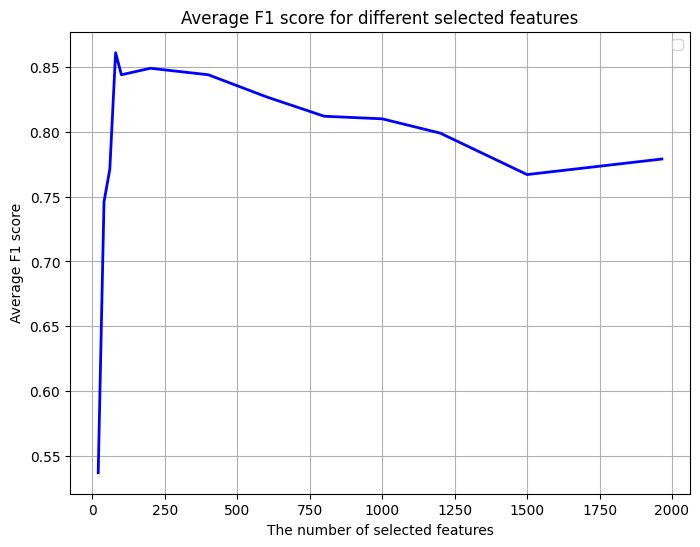

In [ ]:
# We ran multiple simulation and write down the performance for different number of selected features
x = np.array([20,40,60,80,100,200,400,600,800,1000,1200,1500,1965])
y = np.array([0.537, 0.746, 0.771, 0.861, 0.844, 0.849, 0.844, 0.827, 0.812, 0.810, 0.799, 0.767, 0.779])

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='b', linewidth=2)
plt.title('Average F1 score for different selected features')
plt.xlabel('The number of selected features')
plt.ylabel('Average F1 score')
plt.legend()

plt.grid(True)

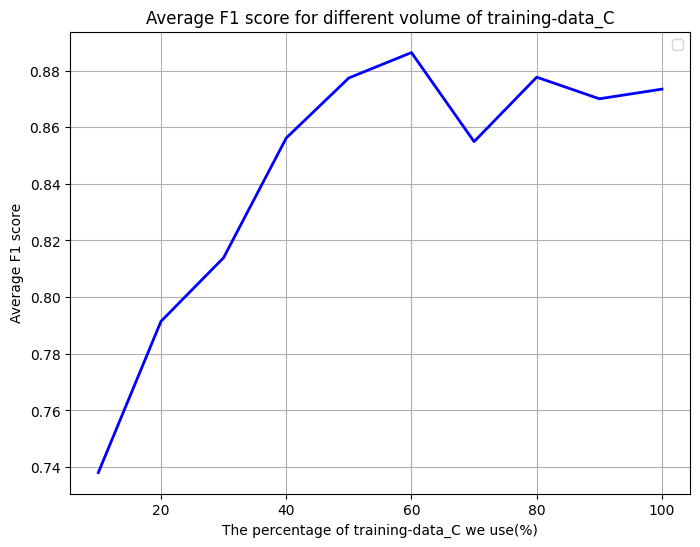

In [ ]:
# We ran multiple simulation and write down the performance for different number data we use from train_data_C
x = np.array([10,20,30,40,50,60,70,80,90,100])
y = np.array([0.737982, 0.791402, 0.813875, 0.856156, 0.877387, 0.886344, 0.854891, 0.877659, 0.870024, 0.873435])

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='b', linewidth=2)
plt.title('Average F1 score for different volume of training-data_C')
plt.xlabel('The percentage of training-data_C we use(%)')
plt.ylabel('Average F1 score')
plt.legend()

plt.grid(True)